In [1]:
# standard library
import sys, os
sys.path.append(os.path.join(".."))
from pprint import pprint
import json

# data and nlp
import pandas as pd
import spacy
nlp = spacy.load("en_core_web_sm")

# visualisation
import pyLDAvis
pyLDAvis.enable_notebook()
import seaborn as sns
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 20,10


# LDA tools
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from utils import lda_utils

# warnings
import logging, warnings
warnings.filterwarnings('ignore')
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

/home/cds-au608644/cds-language/lang101/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
[nltk_data] Downloading package stopwords to /home/cds-
[nltk_data]     au608644/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load in the dataset containing all the lines from all the characters of all the Star Trek series
# Unfortunately, some newlines have been parsed wrong, so that some words are 'glued' togehter. E.g. "camefrom"

with open('all_series_lines.json') as file:
    content = file.read()
    line_dict = json.loads(content)
    
print(line_dict)
    

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [3]:
# convert to dataframe
pd.DataFrame(line_dict)

,ENT,DS9,TOS,TAS,TNG,VOY
episode 0,"{'KLAANG': ['', '', 'Pung ghap! Pung ghap!', '...","{'JENNIFER': ['Hey!', 'Yes?', 'I'm sorry did w...","{'HASKINS': ['Doctor Theodore Haskins, America...","{'MCCOY': ['If its pull is this strong, Jim, h...","{'BAILIFF': ['The prisoners will all stand.', ...",{'JANEWAY': ['Tom Paris? Kathryn Janeway. I se...
episode 1,"{'KLAANG': [], 'DOCK': [], 'ARCHER': ['Come in...","{'JENNIFER': [], 'OPS': [], 'JASAD': [], 'PICA...","{'HASKINS': [], 'TALOSIAN': [], 'GEOLOGIST': [...","{'MCCOY': ['Who's he, Jim?', 'Afraid I don't, ...","{'BAILIFF': [], 'MCCOY': [], 'PICARD': ['Repor...",{'JANEWAY': ['What about alternative energy so...
episode 2,"{'KLAANG': [], 'DOCK': [], 'ARCHER': ['T'Pol.'...","{'JENNIFER': [], 'OPS': [], 'JASAD': [], 'PICA...","{'HASKINS': [], 'TALOSIAN': [], 'GEOLOGIST': [...","{'MCCOY': ['Jim, if we can't stop it, millions...","{'BAILIFF': [], 'MCCOY': [], 'PICARD': ['On ou...","{'JANEWAY': ['Report!', 'Mister Paris, can you..."
episode 3,"{'KLAANG': [], 'DOCK': [], 'ARCHER': ['Archer ...","{'JENNIFER': [], 'OPS': [], 'JASAD': [], 'PICA...","{'HASKINS': [], 'TALOSIAN': [], 'GEOLOGIST': [...","{'MCCOY': ['Magnolias in blossom. Beautiful.',...","{'BAILIFF': [], 'MCCOY': [], 'PICARD': ['Enlar...",{'JANEWAY': ['Assuming we do find dilithium on...
episode 4,"{'KLAANG': [], 'DOCK': [], 'ARCHER': ['Are we ...","{'JENNIFER': [], 'OPS': [], 'JASAD': [], 'PICA...","{'HASKINS': [], 'TALOSIAN': [], 'GEOLOGIST': [...","{'MCCOY': ['I don't want to think about it.', ...","{'BAILIFF': [], 'MCCOY': [], 'PICARD': ['I don...","{'JANEWAY': ['Personal log,Stardate 48546.2. O..."
...,...,...,...,...,...,...
episode 171,NaN,"{'JENNIFER': [], 'OPS': [], 'JASAD': [], 'PICA...",NaN,NaN,"{'BAILIFF': [], 'MCCOY': [], 'PICARD': ['As a ...",NaN
episode 172,NaN,"{'JENNIFER': [], 'OPS': [], 'JASAD': [], 'PICA...",NaN,NaN,"{'BAILIFF': [], 'MCCOY': [], 'PICARD': ['Repor...",NaN
episode 173,NaN,NaN,NaN,NaN,"{'BAILIFF': [], 'MCCOY': [], 'PICARD': ['Data,...",NaN
episode 174,NaN,NaN,NaN,NaN,"{'BAILIFF': [], 'MCCOY': [], 'PICARD': ['Lieut...",NaN


In [4]:
line_dict['ENT']['episode 60']['ARCHER']

["The most difficult task facing any Captain, any crew, is theloss of a shipmate. We've come here to honour one of our own. In thetime we knew him, he showed us just how much one life can truly matter. We will never forget what he did for us, and for the ship he loved somuch. We will go forward with renewed determination to complete thismission, so that his sacrifice won't just have been for the people onthis ship, but for all the citizens of Earth. TwoWeeks Earlier",
 'Archer.',
 'You heard the man, Travis. Four point nine.',
 'We just got our second wind.',
 'Drop to impulse.',
 'Trip, status.',
 'Analysis.',
 'Is that what stopped us?',
 'Keep scanning.',
 'Polarise the hull plating.',
 'Then purge the intake manifolds and shut all the exhaust ports.',
 'Go ahead.',
 "On my way. Run a full sensor scan. I want to know what we'redealing with.",
 'Report.',
 'How much time before we can get the engines back online?',
 "You'll be supervising the repairs. I've just come from Sickbay. Tri

In [5]:
# define a dict to contain all documents (episodes) that starts empty 
# (should contain 1 layer of props e.g. DS9_0 with the string content)
# loop through all series
    # loop through all episodes
        # define a string to contain all concatenated lines from persons from the episode
        # loop through all persons
            # maybe tokenize all strings here?
            # concatenate all lines into one string with spaces between
            # concatenate that string onto the episode's string with spaces between
        # add the episode's line to the document dict as documents['{SERIES}_{EPISODE_NUM}']

Research question:

We found a dataset on kaggle.com containing all the raw character-lines for each episode of each series of Star Trek. Since the dataset ranges from the series' beginning in the 60's (TOS) until Enterprise which is from 2001, we are interested in finding any significant changes in the topics dealt with over time.

In order to do this, we will train an LDA model to consider each individual episode from each series and model the topics according to that. We can then vizualise topic changes over time, and see if there's a connection between episode topic changes and the overall series.

In [9]:
# make an empty dictionary
episodes = {}

# loop through all the series
for series_name, series in line_dict.items():
    # loop through all episodes (both the name, and the content)
    for episode_name, episode in series.items():
        # make empty string so we can later add all the characters lines to
        episode_string = ''
        for character_lines in episode.values():
            lines = ' '.join(character_lines)
            # only add the lines if the character has a line, omit all empty lines.
            if len(lines) !=0:
                episode_string += ' '+lines
        episode_key = series_name+'_'+episode_name.split()[1]
        episodes[episode_key] = episode_string
        
episodes_content = list(episodes.values())

In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(episodes_content, min_count=10, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[episodes_content], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [30]:
processed_lines = lda_utils.process_words(episodes_content,nlp, bigram_mod, trigram_mod, allowed_postags=["NOUN"])

In [31]:
# Convert every token to a numerical ID
id2word = corpora.Dictionary(processed_lines)

# Create Corpus: Term Document Frequency
# match each ID to words and count the frequency of the tokens
corpus = [id2word.doc2bow(episode) for episode in processed_lines]

In [32]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=12, 
                                       random_state=100,
                                       chunksize=10,
                                       passes=10,
                                       iterations=100,
                                       per_word_topics=True, 
                                       minimum_probability=0.0)

In [33]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=processed_lines, 
                                     dictionary=id2word, 
                                     coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.607802927628079

Coherence Score:  0.380599802406387


In [34]:
pprint(lda_model.print_topics())

[(0,
  '0.004*"reactor" + 0.003*"shop" + 0.002*"pol" + 0.002*"emory" + '
  '0.002*"webpage" + 0.002*"cabal" + 0.001*"trip" + 0.001*"mayweather" + '
  '0.001*"tucker" + 0.001*"metre"'),
 (1,
  '0.003*"comet" + 0.003*"prophecy" + 0.002*"viper" + 0.002*"silithium" + '
  '0.002*"falow" + 0.001*"allamaraine" + 0.001*"trakor" + 0.001*"winning" + '
  '0.001*"peril" + 0.001*"wager"'),
 (2,
  '0.031*"captain" + 0.021*"doctor" + 0.014*"time" + 0.010*"ship" + '
  '0.010*"life" + 0.009*"planet" + 0.009*"people" + 0.009*"mister" + '
  '0.009*"way" + 0.008*"thing"'),
 (3,
  '0.011*"pol" + 0.010*"tucker" + 0.010*"trip" + 0.008*"vulcan" + '
  '0.006*"xindi" + 0.006*"sphere" + 0.006*"brunt" + 0.005*"degra" + '
  '0.005*"ship" + 0.005*"biosign"'),
 (4,
  '0.026*"ship" + 0.020*"captain" + 0.017*"time" + 0.009*"way" + '
  '0.008*"course" + 0.008*"system" + 0.008*"power" + 0.007*"commander" + '
  '0.007*"weapon" + 0.007*"crew"'),
 (5,
  '0.014*"host" + 0.007*"trill" + 0.003*"symbiont" + 0.003*"vulcan" + '


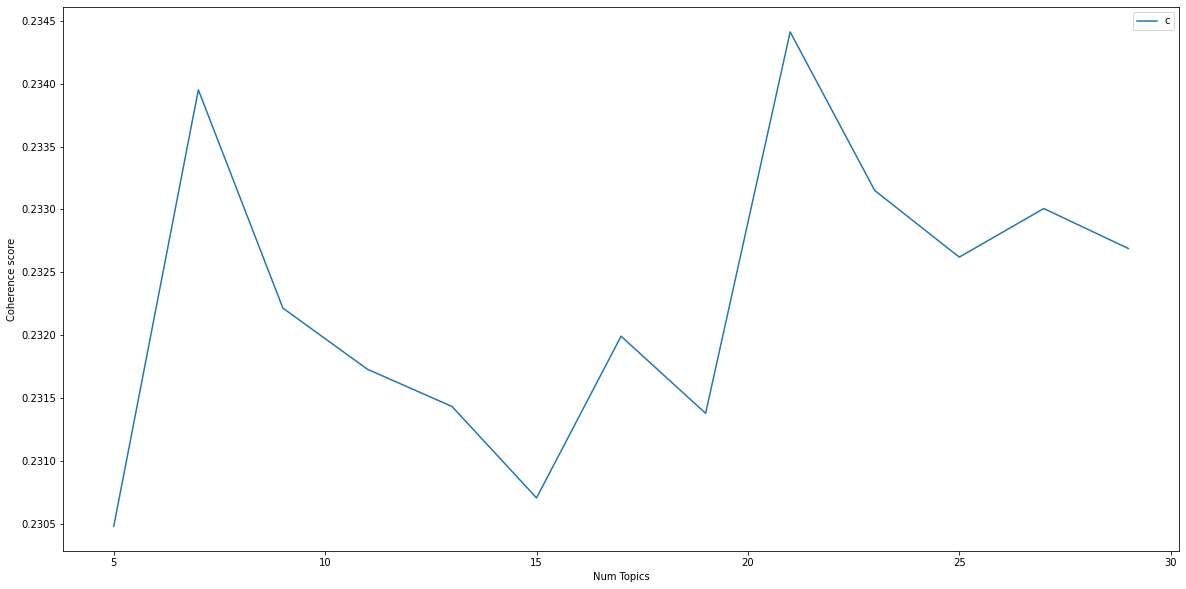

Num Topics = 5  has Coherence Value of 0.2305
Num Topics = 7  has Coherence Value of 0.234
Num Topics = 9  has Coherence Value of 0.2322
Num Topics = 11  has Coherence Value of 0.2317
Num Topics = 13  has Coherence Value of 0.2314
Num Topics = 15  has Coherence Value of 0.2307
Num Topics = 17  has Coherence Value of 0.232
Num Topics = 19  has Coherence Value of 0.2314
Num Topics = 21  has Coherence Value of 0.2344
Num Topics = 23  has Coherence Value of 0.2332
Num Topics = 25  has Coherence Value of 0.2326
Num Topics = 27  has Coherence Value of 0.233
Num Topics = 29  has Coherence Value of 0.2327


In [35]:
# Can take a long time to run.
model_list, coherence_values = lda_utils.compute_coherence_values(texts=processed_lines,
                                                                  corpus=corpus, 
                                                                  dictionary=id2word,  
                                                                  start=5, 
                                                                  limit=30,  
                                                                  step=2)

In [36]:
df_topic_keywords = lda_utils.format_topics_sentences(ldamodel=lda_model, 
                                                      corpus=corpus, 
                                                      texts=processed_lines)

# Format
df_dominant_topic = df_topic_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.sample(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
17,17,10.0,0.5497,"time, way, thing, people, day, man, friend, st...","[vault, want, myship, slave, market, vault, th..."
421,421,2.0,0.5691,"captain, doctor, time, ship, life, planet, peo...","[mister, crusher, planet, moon, datum, planet,..."
50,50,4.0,0.8167,"ship, captain, time, way, course, system, powe...","[attack, kilometre, tovenezuela, casualty, cou..."
136,136,4.0,0.7361,"ship, captain, time, way, course, system, powe...","[truth, thebok, truth, discipline, people, ext..."
282,282,2.0,0.9622,"captain, doctor, time, ship, life, planet, peo...","[magistrate, intelligence, thousand, creature,..."
25,25,4.0,0.7091,"ship, captain, time, way, course, system, powe...","[time, enterprise, colonist, mission, enterpri..."
408,408,2.0,0.5121,"captain, doctor, time, ship, life, planet, peo...","[theorem, equation, margin, note, thenth, solu..."
277,277,2.0,0.9880,"captain, doctor, time, ship, life, planet, peo...","[ship, record, bank, planet, captain, gravity,..."
415,415,2.0,0.5324,"captain, doctor, time, ship, life, planet, peo...","[thought, mister, crusher, flesh, enterprise, ..."
674,674,4.0,0.7325,"ship, captain, time, way, course, system, powe...","[shield, generator, tab, neelix, project, borg..."


# Visualize topics

In [38]:
values = list(lda_model.get_document_topics(corpus))

In [39]:
split = []
for entry in values:
    topic_prevelance = []
    for topic in entry:
        topic_prevelance.append(topic[1])
    split.append(topic_prevelance)

In [40]:
df = pd.DataFrame(map(list,zip(*split)))

In [41]:
df

,0,1,2,3,4,5,6,7,8,9,...,698,699,700,701,702,703,704,705,706,707
0,0.000065,0.000111,0.000129,0.000112,0.123015,0.132568,0.000130,0.211430,0.000129,0.092809,...,0.000116,0.000067,0.000121,0.000165,0.000099,0.000132,0.000153,0.000153,0.000122,0.000070
1,0.000065,0.000111,0.000129,0.000112,0.000133,0.000155,0.075168,0.000153,0.000129,0.000123,...,0.000116,0.000067,0.000121,0.000165,0.000099,0.000132,0.000153,0.000153,0.000122,0.000070
2,0.142977,0.195460,0.613145,0.453994,0.875660,0.399885,0.662147,0.517942,0.000129,0.324381,...,0.016336,0.195727,0.258890,0.019540,0.605524,0.689635,0.341821,0.532009,0.224287,0.017849
3,0.037808,0.000111,0.022420,0.000112,0.000133,0.000155,0.005456,0.000153,0.000129,0.000123,...,0.000116,0.000067,0.000121,0.000165,0.000099,0.000132,0.000153,0.000153,0.000122,0.000070
4,0.760372,0.674161,0.059431,0.264646,0.000133,0.389351,0.130389,0.263207,0.746343,0.433563,...,0.982499,0.459130,0.739904,0.671710,0.000099,0.301932,0.656646,0.442637,0.774497,0.743522
5,0.000065,0.000111,0.000129,0.000112,0.000133,0.000155,0.000130,0.000153,0.000129,0.000123,...,0.000116,0.000067,0.000121,0.000165,0.000099,0.000132,0.000153,0.000153,0.000122,0.000070
6,0.000065,0.000111,0.000129,0.000112,0.000133,0.000155,0.000130,0.000153,0.000129,0.000123,...,0.000116,0.000067,0.000121,0.000165,0.000099,0.000132,0.000153,0.000153,0.000122,0.000070
7,0.000065,0.000111,0.000129,0.000112,0.000133,0.000155,0.000130,0.000153,0.000129,0.000123,...,0.000116,0.000067,0.000121,0.000165,0.000099,0.000132,0.000153,0.000153,0.000122,0.000070
8,0.000065,0.000111,0.000129,0.000112,0.000133,0.000155,0.000130,0.000153,0.000129,0.000123,...,0.000116,0.000067,0.000121,0.000165,0.000099,0.000132,0.000153,0.000153,0.000122,0.000070
9,0.000065,0.000111,0.000129,0.000112,0.000133,0.000155,0.000130,0.000153,0.000129,0.000123,...,0.000116,0.000067,0.000121,0.000165,0.000099,0.000132,0.000153,0.000153,0.000122,0.000070


<AxesSubplot:>

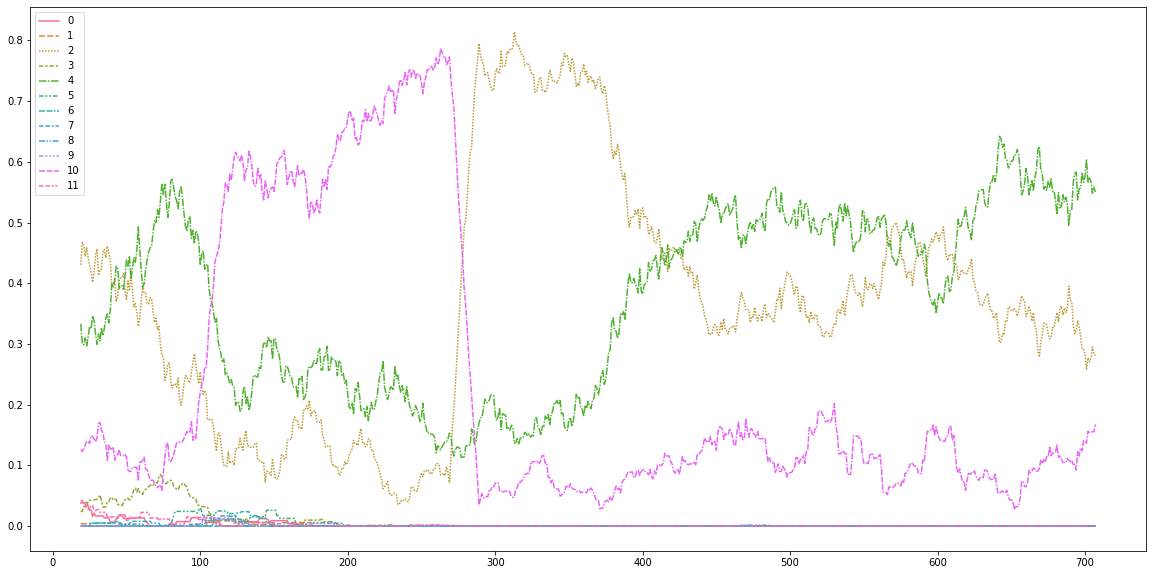

In [43]:
sns.lineplot(data=df.T.rolling(20).mean())